In [53]:
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Auto-Encoders

An Auto-Encoder (AE) is mapping that encodes the input data into a lower dimensional
representation that contains sufficient information to reconstruct the original input.
An autoencoder incorporates two elements:

- An encoder that compresses the data into (encoding)
- A decoder that reconstructs the input given the encoding

We'll use the following notations:

- $x \in \rm{I\!}{R}^d$ an input instance
- $z \in \rm{I\!}{R}^k$ an encoding instance
- $f:x \in \rm{I\!}{R}^d \mapsto z = f(x) \in \rm{I\!}{R}^k$ the encoder
- $g:z\in \rm{I\!}{R}^k \mapsto x = f(x) \in \rm{I\!}{R}^p$ the decoder



## Example

Let's use a neural network $f_\theta$ for our encoder and another network $g_\psi$ for the decoder on the MNIST dataset. 




In [55]:
# Load the data and split it between train and test sets
(x_train, y_train), _ = keras.datasets.mnist.load_data()
# Scale images to the [-1, 1] range
x_train = x_train.astype("float32") / 255.
print(x_train.shape)


(60000, 28, 28)



| <img width=240 src="https://files.aghriss.net/media/images/ae/nn.png"> | <img width=240 src="https://files.aghriss.net/media/images/ae/nnright.png"> |
| :--------------------------------------------------------------------: | :-------------------------------------------------------------------------: |
|                               _encoder_                                |                                  _decoder_                                  |


In [59]:
class Autoencoder(models.Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = models.Sequential([
            layers.Flatten(),
            layers.Dense(256,activation=None),
            layers.LeakyReLU(),
            layers.Dense(256,activation=None),
            layers.LeakyReLU(),
            layers.Dense(256,activation=None),
            layers.LeakyReLU(),
            layers.Dense(latent_dim),
        ])
        self.decoder = models.Sequential([
            layers.Dense(256, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(np.prod(shape), activation='sigmoid'),
            layers.Reshape(shape),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(2, (28,28))
autoencoder.compile(optimizer='adam', loss = keras.losses.MeanSquaredError())

In [60]:
autoencoder.fit(x_train, x_train, epochs=5, shuffle=True)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0501
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0424
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0410
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0402
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0397


1/1 [==============================] - 0s 75ms/step


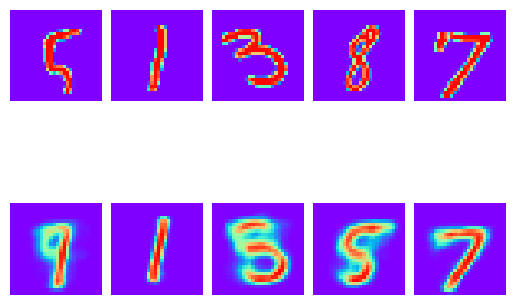

In [61]:
choice = [100, 14234, 6906, 300, 349]

original = x_train[choice]
reconstructed = autoencoder.predict(original)
fig, ax = plt.subplots(2, len(choice))
for i, pair in enumerate(zip(original, reconstructed)):
    for j in range(2):
        ax[j, i].axis('off')
        ax[j, i].imshow(pair[j])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# save the output to file if needed
# plt.savefig("reconstruct.png", transparent=True)
plt.show()


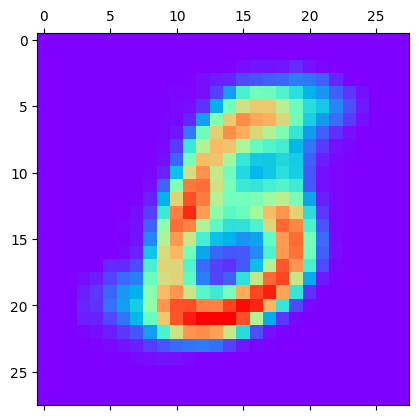

In [67]:
plt.matshow(autoencoder.decoder(np.array([-3,2])[None])[0])


## Exploiting the encoded data

We can use the encoding instead of the original data in many other downstream tasks (classification, clustering, generative models). Let's see how the TSNE embedding of the code matches with the true images labels.

In [68]:
import numpy as np
# subset of size 2000
subset = np.random.choice(len(x_train), 2000, replace=False)
x = x_train[subset].reshape(-1, 28*28)
y = y_train[subset]
code = autoencoder.encoder.predict(x)


63/63 [==============================] - 0s 936us/step


## Visualizing the data via TSNE

In [69]:
from sklearn.manifold import TSNE

embeddings = TSNE(n_components=2).fit_transform(code)


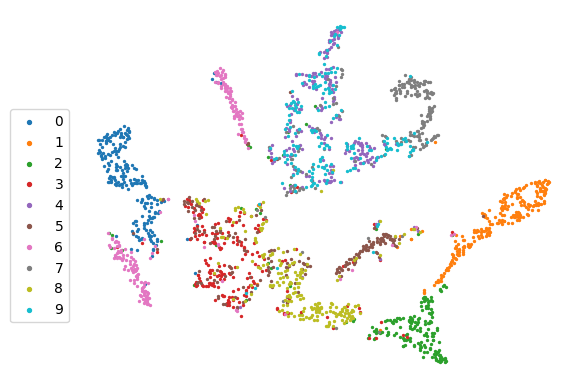

In [70]:
plt.set_cmap("rainbow")
plt.axis("off")
for yy in range(10):
    idx = (y == yy)
    plt.scatter(embeddings[idx, 0], embeddings[idx, 1], s=2, label=yy)

plt.legend(bbox_to_anchor=(0.0, 0.75), markerscale=2)
# save the plot if needed
# plt.savefig("tsne.png", transparent=True)
plt.show()